In [2]:
%load_ext autoreload
%autoreload 2

from src import detect_faces, show_bboxes
from PIL import Image
import cv2
import numpy as np
from src.align_trans import get_reference_facial_points, warp_and_crop_face
import mxnet as mx
import io
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
face_folder = Path('/home/f/learning/Dataset/faces_vgg_112x112')
bin_path = face_folder/'train.rec'
idx_path = face_folder/'train.idx'

In [4]:
imgrec = mx.recordio.MXIndexedRecordIO(str(idx_path), str(bin_path), 'r')

HEADER(flag=0, label=2.0, id=813, id2=0)


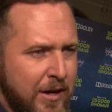

In [25]:
i =813

img_info = imgrec.read_idx(i)

header, img = mx.recordio.unpack(img_info)

encoded_jpg_io = io.BytesIO(img)

image = Image.open(encoded_jpg_io)

print(header)
image

In [26]:
image.size

(112, 112)

In [27]:
bounding_boxes, landmarks = detect_faces(image)

In [28]:
bounding_boxes,landmarks

(array([[ 13.36201936,   5.58984986,  78.93511893, 104.44713098,
           0.99996698]]),
 array([[45.040733, 73.22949 , 67.01588 , 46.294598, 68.35203 , 47.975132,
         46.75182 , 68.91486 , 85.37722 , 84.38674 ]], dtype=float32))

In [36]:
from tqdm import tqdm
faces = []
img_cv2 = np.array(image)[...,::-1]
for i in tqdm(range(len(bounding_boxes))):
    box = bounding_boxes[i][:4].astype(np.int32).tolist()
    for idx, coord in enumerate(box[:2]):
        if coord > 1:
            box[idx] -= 1
    if box[2] + 1 < img_cv2.shape[1]:
        box[2] += 1
    if box[3] + 1 < img_cv2.shape[0]:
        box[3] += 1
    face = img_cv2[box[1]:box[3],box[0]:box[2]]
    landmark = landmarks[i]
    facial5points = [[landmark[j] - box[0],landmark[j+5] - box[1]] for j in range(5)]
    dst_img = warp_and_crop_face(face,facial5points, crop_size=(112,112))
    faces.append(Image.fromarray(dst_img[...,::-1]))

  0%|          | 0/1 [00:00<?, ?it/s]


FaceWarpException: In File /root/Notebooks/face/mtcnn-pytorch/src/align_trans.py:FaceWarpException('No paddings to do, output_size must be None or [ 96 112]',)

In [38]:
reference_pts = get_reference_facial_points(default_square= True)

In [40]:
dst_img = warp_and_crop_face(face, facial5points, reference_pts, crop_size=(112,112))

/root/Notebooks/face/mtcnn-pytorch/src/matlab_cp2tform.py:90: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  r, _, _, _ = lstsq(X, U)


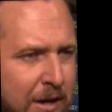

In [43]:
Image.fromarray(dst_img[...,::-1])